# Q3: CNN for image classification

In this assignment, you'll be coding up a convolutional neural network from scratch to classify images using PyTorch.  

### Instructions
- Install PyTorch following the instructions [here](https://pytorch.org/).
- Install the [`torchinfo` package](https://github.com/TylerYep/torchinfo) to visualize the network architecture and the number of parameters. The maximum number of parameters you are allowed to use for your network is **100,000**. Those who violate this rule will be scored 0 points!!! 
- You are required to complete the functions defined in the code blocks following each question. Fill out sections of the code marked `"YOUR CODE HERE"`.
- You're free to add any number of methods within each class.
- You may also add any number of additional code blocks that you deem necessary. 

## Data Preparation

In [1]:
# Importing the libraries
import os
import torch
import torchvision
from torchvision.utils import make_grid

import numpy as np

/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In this assignment, we will use the EMNIST dataset. The EMNIST dataset is a set of handwritten character digits derived from the NIST Special Database 19 and converted to a 28x28 pixel image format and dataset structure that directly matches the MNIST dataset.

There are six different splits provided in this datase: byclass, bymerge, balanced, letters, digits and mnist. Here, we will choose 'balanced' split.

Further information on the dataset contents and conversion process can be found in the paper available at https://arxiv.org/abs/1702.05373v1.



### Data

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255.  


EMNIST is included in the `torchvision` library.

In [2]:
from torchvision.datasets import EMNIST
from torchvision.transforms import Compose, ToTensor, Normalize

In [3]:
# Transform to normalize the data and convert to a tensor
transform = Compose([ToTensor(),
    Normalize((0.5,), (0.5,))
    ])

# Download the data
dataset = EMNIST('MNIST_data/', download = True, train = True, split = 'balanced', transform = transform)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 561753746/561753746 [03:10<00:00, 2944729.68it/s]


Extracting MNIST_data/EMNIST/raw/gzip.zip to MNIST_data/EMNIST/raw


**NOTE:** You may add more operations to `Compose` if you're performing data augmentation.

## Data Exploration

Let's take a look at the classes in our dataset.

In [28]:
print(dataset.classes)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']


#### import matplotlib.pyplot as plt

def show_example(img, label):
    print('Label: {} ({})'.format(dataset.classes[label], label))
    plt.imshow(img.squeeze(), cmap='Greys_r')
    plt.axis(False)

Label: h (42)


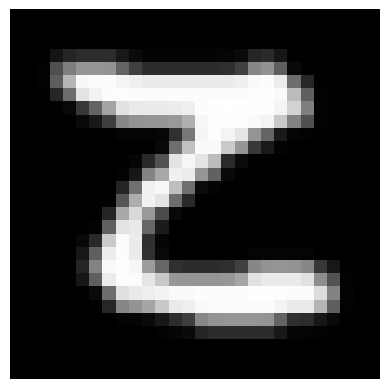

In [6]:
show_example(*dataset[20])

Label: A (10)


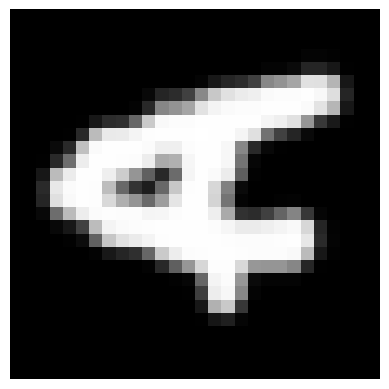

In [7]:
show_example(*dataset[20000])

## Question 1 (2 points)

## Creating Training and Validation Datasets

The `split_indices` function takes in the size of the entire dataset, `n`, the fraction of data to be used as validation set, `val_frac`, and the random seed and returns the indices of the data points to be added to the validation dataset.  

**Choose a suitable fraction for your validation set and experiment with the seed. Remember that the better your validation set, the higher the chances that your model would do well on the test set.**

In [8]:
def split_indices(n, val_frac, seed):
    # Determine the size of the validation set
    n_val = int(val_frac * n)
    np.random.seed(seed)
    # Create random permutation between 0 to n-1
    idxs = np.random.permutation(n)
    # Pick first n_val indices for validation set
    return idxs[n_val:], idxs[:n_val]

In [9]:
######################
#   YOUR CODE HERE   #
######################
val_frac = 0.5 ## Set the fraction for the validation set
rand_seed = 42 ## Set the random seed

train_indices, val_indices = split_indices(len(dataset), val_frac, rand_seed)
print("#samples in training set: {}".format(len(train_indices)))
print("#samples in validation set: {}".format(len(val_indices)))

#samples in training set: 56400
#samples in validation set: 56400


Next, we make use of the built-in dataloaders in PyTorch to create iterables of our our training and validation sets. This helps in avoiding fitting the whole dataset into memory and only loads a batch of the data that we can decide. 

**Set the `batch_size` depending on the hardware resource (GPU/CPU RAM) you are using for the assignment.**

In [10]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [11]:
######################
#   YOUR CODE HERE   #
######################
batch_size = 8 ## Set the batch size

In [12]:
# Training sampler and data loader
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset,
                     batch_size,
                     sampler=train_sampler)

# Validation sampler and data loader
val_sampler = SubsetRandomSampler(val_indices)
val_dl = DataLoader(dataset,
                   batch_size,
                   sampler=val_sampler)

Plot images in a sample batch of data.

In [13]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(10,10))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, 8).permute(1, 2, 0), cmap='Greys_r')
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


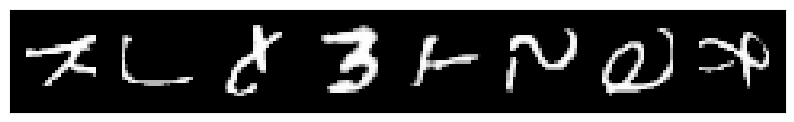

In [14]:
show_batch(train_dl)

## Question 2 (10 points)

## Building the Model

**Create your model by defining the network architecture in the `ImageClassifierNet` class.**  
**NOTE:** The number of parameters in your network must be $\leq$ 100,000.

In [50]:
# Import the libraries
import torch.nn as nn
import torch.nn.functional as F

from torchinfo import summary
from tqdm import tqdm

In [38]:
class ImageClassifierNet(nn.Module):
    def __init__(self, n_channels=1):
        super(ImageClassifierNet, self).__init__()
        ######################
        #   YOUR CODE HERE   #
        ######################
        self.conv1 = nn.Conv2d(n_channels, 16, kernel_size=3, stride=1, padding=1) 
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size = 2) 
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1) 
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size = 2)

        self.conv3 = nn.Conv2d(32, 48, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(48)
        self.pool3 = nn.MaxPool2d(kernel_size = 2)

        self.fc1 = nn.Linear(48 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 47)

        
    def forward(self, X):
        ######################
        #   YOUR CODE HERE   #
        ######################
        x = F.relu(self.pool1(self.bn1(self.conv1(X))))
        x = F.relu(self.pool2(self.bn2(self.conv2(x))))
        x = F.relu(self.pool3(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.fc2(F.relu(self.fc1(x)))
        return self.fc3(F.relu(x))
        

In [39]:
model = ImageClassifierNet()

The following code block prints your network architecture. It also shows the total number of parameters in your network (see `Total params`).  

**NOTE: The total number of parameters in your model should be <= 100,000.**

In [40]:
summary(model, input_size=(batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
ImageClassifierNet                       [8, 47]                   --
├─Conv2d: 1-1                            [8, 16, 28, 28]           160
├─BatchNorm2d: 1-2                       [8, 16, 28, 28]           32
├─MaxPool2d: 1-3                         [8, 16, 14, 14]           --
├─Conv2d: 1-4                            [8, 32, 14, 14]           4,640
├─BatchNorm2d: 1-5                       [8, 32, 14, 14]           64
├─MaxPool2d: 1-6                         [8, 32, 7, 7]             --
├─Conv2d: 1-7                            [8, 48, 7, 7]             13,872
├─BatchNorm2d: 1-8                       [8, 48, 7, 7]             96
├─MaxPool2d: 1-9                         [8, 48, 3, 3]             --
├─Linear: 1-10                           [8, 128]                  55,424
├─Linear: 1-11                           [8, 64]                   8,256
├─Linear: 1-12                           [8, 47]                   3,0

## Enable training on a GPU

**NOTE:** This section is necessary if you're training your model on a GPU.

In [41]:
def get_default_device():
    """Use GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [42]:
device = get_default_device()

train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

to_device(model, device)

ImageClassifierNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=432, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=47, bias=True)
)

## Question 3 (10 points)

## Train the model

**Complete the `train_model` function to train your model on a dataset. Tune your network architecture and hyperparameters on the validation set.**

In [54]:
def train_model(n_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr):
    """
    Trains the model on a dataset.
    
    Args:
        n_epochs: number of epochs
        model: ImageClassifierNet object
        train_dl: training dataloader
        val_dl: validation dataloader
        loss_fn: the loss function
        opt_fn: the optimizer
        lr: learning rate
    
    Returns:
        The trained model. 
        A tuple of (model, train_losses, val_losses, train_accuracies, val_accuracies)
    """
    # Record these values the end of each epoch
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    
    ######################
    #   YOUR CODE HERE   #
    ######################
    optimizer = opt_fn(model.parameters(), lr=lr)
    for epoch in range(n_epochs):
        model.train()

        epoch_train_loss = 0
        correct_train = 0
        total_train = 0
        
        for img, label in tqdm(train_dl, desc=f"Training process in epoch {epoch}"):
            output = model(img)
            loss = loss_fn(output, label)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()
            _, predicted = torch.max(output, 1)
            correct_train += (predicted == label).sum().item()
            total_train += label.size(0)
            
        train_loss = epoch_train_loss / len(train_dl)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validation phase
        model.eval()
        
        epoch_val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for img, label in tqdm(val_dl, desc=f"Testing process in epoch {epoch}"):
                
                output = model(img)
                loss = loss_fn(output, label)
                
                epoch_val_loss += loss.item()
                _, predicted = torch.max(output, 1)
                correct_val += (predicted == label).sum().item()
                total_val += label.size(0)
        
        val_loss = epoch_val_loss / len(val_dl)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{n_epochs}:")
        print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        
        
    
    return model, train_losses, val_losses, train_accuracies, val_accuracies

**Set the maximum number of training epochs, the loss function, the optimizer, and the learning rate.**

In [55]:
######################
#   YOUR CODE HERE   #
######################
num_epochs = 20  # Max number of training epochs
loss_fn = loss_fn = torch.nn.CrossEntropyLoss() # Define the loss function
opt_fn = torch.optim.Adam # Select an optimizer
lr = 0.01 # Set the learning rate

In [ ]:
history = train_model(num_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr)
model, train_losses, val_losses, train_accuracies, val_accuracies = history

Testing process in epoch 0: 100%|██████████████████████████████████████████████████████████████████████████████| 7050/7050 [00:19<00:00, 367.77it/s]


Epoch 1/20:
  Train Loss: 0.7160, Train Accuracy: 0.7673
  Val Loss: 0.8896, Val Accuracy: 0.7588


Testing process in epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████| 7050/7050 [00:19<00:00, 361.05it/s]


Epoch 2/20:
  Train Loss: 0.6946, Train Accuracy: 0.7770
  Val Loss: 0.7093, Val Accuracy: 0.7745


Testing process in epoch 2: 100%|██████████████████████████████████████████████████████████████████████████████| 7050/7050 [00:19<00:00, 359.99it/s]


Epoch 3/20:
  Train Loss: 0.6779, Train Accuracy: 0.7802
  Val Loss: 0.7880, Val Accuracy: 0.7824


Testing process in epoch 3: 100%|██████████████████████████████████████████████████████████████████████████████| 7050/7050 [00:19<00:00, 369.63it/s]


Epoch 4/20:
  Train Loss: 0.6589, Train Accuracy: 0.7870
  Val Loss: 0.6692, Val Accuracy: 0.7939


Testing process in epoch 4: 100%|██████████████████████████████████████████████████████████████████████████████| 7050/7050 [00:19<00:00, 371.02it/s]


Epoch 5/20:
  Train Loss: 0.6490, Train Accuracy: 0.7894
  Val Loss: 0.6260, Val Accuracy: 0.8061


Testing process in epoch 5: 100%|██████████████████████████████████████████████████████████████████████████████| 7050/7050 [00:18<00:00, 379.13it/s]


Epoch 6/20:
  Train Loss: 0.6459, Train Accuracy: 0.7907
  Val Loss: 0.7644, Val Accuracy: 0.7635


Testing process in epoch 6: 100%|██████████████████████████████████████████████████████████████████████████████| 7050/7050 [00:18<00:00, 373.02it/s]


Epoch 7/20:
  Train Loss: 0.6398, Train Accuracy: 0.7918
  Val Loss: 0.7569, Val Accuracy: 0.7770


Testing process in epoch 7: 100%|██████████████████████████████████████████████████████████████████████████████| 7050/7050 [00:19<00:00, 368.23it/s]


Epoch 8/20:
  Train Loss: 0.6365, Train Accuracy: 0.7941
  Val Loss: 0.6775, Val Accuracy: 0.7929


Testing process in epoch 8: 100%|██████████████████████████████████████████████████████████████████████████████| 7050/7050 [00:18<00:00, 377.91it/s]


Epoch 9/20:
  Train Loss: 0.6352, Train Accuracy: 0.7948
  Val Loss: 0.7317, Val Accuracy: 0.7659


Testing process in epoch 9: 100%|██████████████████████████████████████████████████████████████████████████████| 7050/7050 [00:18<00:00, 375.63it/s]


Epoch 10/20:
  Train Loss: 0.6279, Train Accuracy: 0.7973
  Val Loss: 0.6732, Val Accuracy: 0.8034


Testing process in epoch 10: 100%|█████████████████████████████████████████████████████████████████████████████| 7050/7050 [00:19<00:00, 368.24it/s]


Epoch 11/20:
  Train Loss: 0.6253, Train Accuracy: 0.7992
  Val Loss: 0.6485, Val Accuracy: 0.7967


Testing process in epoch 11: 100%|█████████████████████████████████████████████████████████████████████████████| 7050/7050 [00:20<00:00, 346.21it/s]


Epoch 12/20:
  Train Loss: 0.6280, Train Accuracy: 0.7999
  Val Loss: 0.7141, Val Accuracy: 0.7914


Training process in epoch 12:  29%|██████████████████████▎                                                     | 2067/7050 [00:13<00:30, 161.97it/s]

## Plot loss and accuracy

In [ ]:
def plot_accuracy(train_accuracies, val_accuracies):
    """Plot accuracies"""
    plt.plot(train_accuracies, "-x")
    plt.plot(val_accuracies, "-o")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["Training", "Validation"])
    plt.title("Accuracy vs. No. of epochs")

In [ ]:
plot_accuracy(train_accuracies, val_accuracies)

In [ ]:
def plot_losses(train_losses, val_losses):
    """Plot losses"""
    plt.plot(train_losses, "-x")
    plt.plot(val_losses, "-o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Training", "Validation"])
    plt.title("Loss vs. No. of Epochs")

In [ ]:
plot_losses(train_losses, val_losses)

## Train a model on the entire dataset

In [ ]:
indices, _ = split_indices(len(dataset), 0, rand_seed)

sampler = SubsetRandomSampler(indices)
dl = DataLoader(dataset, batch_size, sampler=sampler)
dl = DeviceDataLoader(dl, device)

**Set the maximum number of training epochs and the learning rate for finetuning your model.**

In [ ]:
######################
#   YOUR CODE HERE   #
######################
num_epochs = 20 # Max number of training epochs
lr = 0.01 # Set the learning rate

In [ ]:
history = train_model(num_epochs, model, dl, [], loss_fn, opt_fn, lr)
model = history[0]

## Check Predictions

In [ ]:
def view_prediction(img, label, probs, classes):
    """
    Visualize predictions.
    """
    probs = probs.cpu().numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(8,15), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).cpu().numpy().squeeze(), cmap='Greys_r')
    ax1.axis('off')
    ax1.set_title('Actual: {}'.format(classes[label]))
    ax2.barh(np.arange(10), probs)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(classes, size='small');
    ax2.set_title('Predicted: probabilities')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

In [ ]:
# Calculate the class probabilites (log softmax) for img
images = iter(dl)
for imgs, labels in images:
    with torch.no_grad():
        model.eval()
        # Calculate the class probabilites (log softmax) for img
        probs = torch.nn.functional.softmax(model(imgs[0].unsqueeze(0)), dim=1)
        # Plot the image and probabilites
        view_prediction(imgs[0], labels[0], probs, dataset.classes)
    break

## Save the model

In [ ]:
# Very important
torch.save(model, 'model.pth')

## Question 4 (8 points)

## Compute accuracy on the test set

In [ ]:
test_dataset = EMNIST('MNIST_data/', download = True, train = False, split = 'balanced', transform = transform)

In [ ]:
test_dl = DataLoader(test_dataset, batch_size)
test_dl = DeviceDataLoader(test_dl, device)

In [ ]:
def evaluate(model, test_dl):
    """
    Evaluates your model on the test data.
    
    Args:
        model: ImageClassifierNet object
        test_dl: test dataloader
    
    Returns: 
        Test accuracy.
    """
    ######################
    #   YOUR CODE HERE   #
    ######################
    model.eval()

    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for img, label in val_dl:
            output = model(img)
            
            _, predicted = torch.max(output, 1)
            correct_val += (predicted == label).sum().item()
            total_val += label.size(0)
    
    return correct_val / total_val

     

In [ ]:
print("Test Accuracy = {:.4f}".format(evaluate(model, test_dl)))

## Tips to increase the test accuracy

- **Data augmentation:** Diversifies your training set and leads to better generalization
    - Flipping
    - Rotation
    - Shifting
    - Cropping
    - Adding noise
    - Blurring
    
- **Regularization:** Reduces overfitting on the training set
    - Early stopping
    - Dropout
    - $l_2$ regularization
    - Batch normalization

- **Hyperparameter tuning:**
    - Weight initialization
    - Learning rate
    - Activation functions
    - Optimizers